In [1]:
# Imports
import importlib
from collections import Counter
import src.data.CMU_dataset_dataloader as CMU_dataset_dataloader
import src.utils.data_utils as data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

importlib.reload(CMU_dataset_dataloader)
importlib.reload(data_utils)

# Constants
CMU_DATA_DOWNLOAD_PATH = 'https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
CMU_DATA_PATH_INITIAL = 'data/initial/'
CMU_DATA_PREPROCESSED_PATH = 'data/preprocessed/'

sns.set_palette("colorblind") 
sns.set_style("whitegrid")

In [2]:
# Load the movie metadata
print("\nLoading Movie Metadata...")


categories = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
]

movies = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'movie.metadata.tsv', categories=categories)
df_movies = movies.data

print("\nSample of Movie Metadata:")
display(df_movies.sample(5))

print("\nData Summary:")
print(df_movies.info())

missing_values = df_movies.isnull().sum()
print("\nMissing Values by Column:")
print(missing_values[missing_values > 0])


Loading Movie Metadata...

Sample of Movie Metadata:


,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
35345,28115795,/m/0cm9yqs,Essential Killing,2010-09-06,NaN,83.0,"{""/m/05qqm"": ""Polish Language"", ""/m/0jzc"": ""Ar...","{""/m/05qhw"": ""Poland"", ""/m/03rt9"": ""Ireland"", ...","{""/m/01jfsb"": ""Thriller"", ""/m/03k9fj"": ""Advent..."
80939,25084392,/m/09gdy57,Beyond the Pole,2009,NaN,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0gf28"": ""Parody"", ""/m/05h0n"": ""Nature"", ""..."
25691,9915982,/m/06_y4v_,La Caída,1959,NaN,84.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/01g6gs"": ""Black-and-white""}"
28785,35249151,/m/0crt5y4,Nanak Naam Jahaz Hai,1969,NaN,133.0,"{""/m/0688f"": ""Punjabi language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
59188,19136347,/m/04jkvmh,Day of the Assassin,NaN,NaN,NaN,{},"{""/m/0b90_r"": ""Mexico"", ""/m/06mkj"": ""Spain"", ""...","{""/m/02kdv5l"": ""Action"", ""/m/03k9fj"": ""Adventu..."



Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wikipedia_movie_id  81741 non-null  int64  
 1   freebase_movie_id   81741 non-null  object 
 2   movie_name          81741 non-null  object 
 3   release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   runtime             61291 non-null  float64
 6   languages           81741 non-null  object 
 7   countries           81741 non-null  object 
 8   genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB
None

Missing Values by Column:
release_date           6902
box_office_revenue    73340
runtime               20450
dtype: int64


In [3]:
df_movies = df_movies.copy()

# Removing freebase (deprecated)
if 'freebase_movie_id' in df_movies.columns:
    df_movies.drop(columns=['freebase_movie_id'], inplace=True)

df_movies = df_movies.dropna(subset=['box_office_revenue'])

assert df_movies['box_office_revenue'].isnull().sum() == 0

df_movies['languages'] = df_movies['languages'].apply(data_utils.convert_to_dict)
df_movies['countries'] = df_movies['countries'].apply(data_utils.convert_to_dict)

In [4]:
print("Loading Plot Summaries...")

# Specify only the necessary columns for loading
categories = ['movie_id', 'summary']

# Load data
plots = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'plot_summaries.txt', categories=categories)
df_plots = plots.data

print("\nSample of Plot Summaries:")
display(df_plots.sample(5))

print("\nPlot Summaries Data Summary:")
print(df_plots.info())

# Check for missing values in 'summary' column
missing_values = df_plots['summary'].isnull().sum()
if missing_values > 0:
    print(f"\nWarning: There are {missing_values} missing values in the 'summary' column.")
else:
    print("\nNo missing values in the 'summary' column.")

Loading Plot Summaries...

Sample of Plot Summaries:


,movie_id,summary
11875,32996032,Saroj Kumar is a matinee idol and megastar in ...
5203,90039,"Mel Coplin and his wife, Nancy, live in New Yo..."
9468,2637077,"Hilary O'Neil is a pretty, outgoing yet cauti..."
9733,31981493,"Uuno's father-in-law, Councillor Tuura, is los..."
17757,7922200,Released from prison In Illinois after serving...



Plot Summaries Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  42303 non-null  int64 
 1   summary   42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB
None

No missing values in the 'summary' column.


count    42303.000000
mean      1784.034300
std       1808.925641
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64


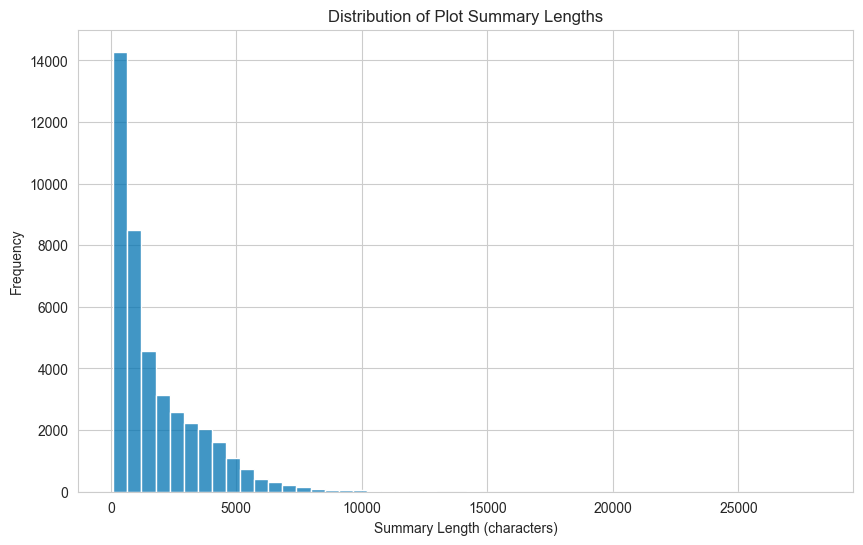

,movie_id,summary,summary_length
9140,3493556,The horrors of war are examined from the view ...,868
41877,171066,"Born and raised in a small Tennessee town, Ann...",1653
16994,35182419,"Shin Jin-ah , onetime lead singer of popular g...",1309
3992,32872222,"After the park guests leave, Donald and the be...",897
31769,24112022,The film tells the story of a Polish Resistanc...,421


In [5]:
assert df_plots['summary'].isnull().sum() == 0, "Missing values found in 'summary' column"
assert df_plots['movie_id'].isnull().sum() == 0, "Missing values found in 'movie_id' column"

# Average plot summary length
df_plots['summary_length'] = df_plots['summary'].apply(len)
print(df_plots['summary_length'].describe())

df_plots.to_csv(CMU_DATA_PREPROCESSED_PATH + 'plot_summaries.csv', index=False)

# summary lengths distribution
plt.figure(figsize=(10,6))
sns.histplot(df_plots['summary_length'], bins=50)
plt.title('Distribution of Plot Summary Lengths')
plt.xlabel('Summary Length (characters)')
plt.ylabel('Frequency')
plt.show()

df_plots.sample(5)

In [6]:
# Sentiment Analysis
#Vader
#%pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [7]:
analyzer = SentimentIntensityAnalyzer()
df_plots['vader_scores'] = df_plots['summary'].apply(lambda x: analyzer.polarity_scores(x))

df_plots.head(5)

,movie_id,summary,summary_length,vader_scores
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"{'neg': 0.083, 'neu': 0.832, 'pos': 0.084, 'co..."
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"{'neg': 0.132, 'neu': 0.791, 'pos': 0.077, 'co..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"{'neg': 0.178, 'neu': 0.704, 'pos': 0.119, 'co..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"{'neg': 0.111, 'neu': 0.786, 'pos': 0.103, 'co..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"{'neg': 0.108, 'neu': 0.825, 'pos': 0.067, 'co..."


In [8]:
%pip install textblob
from textblob import TextBlob

df_plots.sample(20)
# Function to get TextBlob sentiment
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment

# Apply TextBlob sentiment analysis
df_plots['textblob_sentiment'] = df_plots['summary'].apply(get_textblob_sentiment)

df_plots.head(5)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,movie_id,summary,summary_length,vader_scores,textblob_sentiment
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"{'neg': 0.083, 'neu': 0.832, 'pos': 0.084, 'co...","(0.2, 0.6)"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"{'neg': 0.132, 'neu': 0.791, 'pos': 0.077, 'co...","(0.04526106934001671, 0.4072451963241437)"
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"{'neg': 0.178, 'neu': 0.704, 'pos': 0.119, 'co...","(0.04954954954954956, 0.3684684684684684)"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"{'neg': 0.111, 'neu': 0.786, 'pos': 0.103, 'co...","(0.03054998514557338, 0.47620692216280447)"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"{'neg': 0.108, 'neu': 0.825, 'pos': 0.067, 'co...","(0.06391293891293891, 0.4222582972582973)"


In [9]:
merged_df = df_plots.merge(df_movies, left_on='movie_id', right_on='wikipedia_movie_id', how='inner')

merged_df = merged_df.drop(columns=['wikipedia_movie_id', 'release_date', 'runtime', 'languages', 'countries', 'genres'])
merged_df.sample(5)

,movie_id,summary,summary_length,vader_scores,textblob_sentiment,movie_name,box_office_revenue
2712,3158499,"Bishop , Q , Raheem and Steel , who refer to ...",4332,"{'neg': 0.174, 'neu': 0.754, 'pos': 0.072, 'co...","(0.013303099017384737, 0.4099853189138903)",Juice,20146880.0
6494,8481,Kate Miller is a sexually frustrated housewife...,3359,"{'neg': 0.109, 'neu': 0.845, 'pos': 0.046, 'co...","(0.0015323691460055113, 0.44671143250688716)",Dressed to Kill,31899000.0
4404,386124,{{story}} On a cold winter Saturday in Chicago...,2811,"{'neg': 0.125, 'neu': 0.815, 'pos': 0.06, 'com...","(0.008008658008658005, 0.37978896103896104)",Barbershop,77063924.0
137,3569886,A former police detective in New Orleans and a...,2122,"{'neg': 0.168, 'neu': 0.776, 'pos': 0.057, 'co...","(0.028865578865578872, 0.4267538017538018)",Heaven's Prisoners,5009305.0
1161,18070237,When spoiled younger sister Valerie Colby bec...,1953,"{'neg': 0.087, 'neu': 0.735, 'pos': 0.178, 'co...","(0.09037878787878786, 0.43042929292929283)",Double Harness,493000.0


In [10]:
merged_df.sort_values(by='box_office_revenue', ascending=False, inplace=True)
# Divide movies into 4 groups based on box office revenue
merged_df['box_office_group'] = pd.qcut(merged_df['box_office_revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
merged_df.head(5)


,movie_id,summary,summary_length,vader_scores,textblob_sentiment,movie_name,box_office_revenue,box_office_group
5509,4273140,"By 2154, humans have severely depleted Earth'...",2928,"{'neg': 0.153, 'neu': 0.747, 'pos': 0.1, 'comp...","(-0.032613636363636365, 0.4267045454545454)",Avatar,2.782275e+09,Very High
5083,52371,"In 1996, treasure hunter Brock Lovett and his...",5079,"{'neg': 0.104, 'neu': 0.786, 'pos': 0.11, 'com...","(0.279803550207962, 0.6566436423054071)",Titanic,2.185372e+09,Very High
6746,22114132,"The Asgardian Loki encounters the Other, the ...",4154,"{'neg': 0.094, 'neu': 0.858, 'pos': 0.048, 'co...","(-0.04942067736185382, 0.44446142093200913)",The Avengers,1.511758e+09,Very High
7517,31941988,{{further2}} {{See also}} As Lord Voldemort r...,4402,"{'neg': 0.228, 'neu': 0.713, 'pos': 0.059, 'co...","(0.07083333333333333, 0.4470238095238095)",Harry Potter and the Deathly Hallows – Part 2,1.328111e+09,Very High
874,25001260,"In 1961, the Ark, a Cybertronian spacecraft c...",4468,"{'neg': 0.132, 'neu': 0.81, 'pos': 0.058, 'com...","(-0.07510822510822514, 0.4051948051948053)",Transformers: Dark of the Moon,1.123747e+09,Very High


# Sentimental analysis

## Analysis Sentiment scores

In [13]:
import plotly.express as px
import plotly.graph_objects as go

# Generate VADER Sentiment Distributions
box_office_groups = merged_df['box_office_group'].unique()
fig = go.Figure()

# Add traces for compound, positive, negative, and neutral scores
for group in box_office_groups:
    group_data = merged_df[merged_df['box_office_group'] == group]
    compound_scores = group_data['vader_scores'].apply(lambda x: x['compound'])
    positive_scores = group_data['vader_scores'].apply(lambda x: x['pos'])
    negative_scores = group_data['vader_scores'].apply(lambda x: x['neg'])
    neutral_scores = group_data['vader_scores'].apply(lambda x: x['neu'])
    
    # Compound
    fig.add_trace(go.Histogram(
        x=compound_scores,
        name=f'{group} - Compound',
        opacity=0.6
    ))
    # Positive
    fig.add_trace(go.Histogram(
        x=positive_scores,
        name=f'{group} - Positive',
        opacity=0.6
    ))
    # Negative
    fig.add_trace(go.Histogram(
        x=negative_scores,
        name=f'{group} - Negative',
        opacity=0.6
    ))
    # Neutral
    fig.add_trace(go.Histogram(
        x=neutral_scores,
        name=f'{group} - Neutral',
        opacity=0.6
    ))

# Layout adjustments
fig.update_layout(
    title='VADER Sentiment Distributions by Box Office Group',
    barmode='overlay',
    xaxis_title='Sentiment Scores',
    yaxis_title='Frequency',
    template='plotly_white',
    height=600
)

# Show and save
fig.show()
fig.write_html("assets/ploty-img/vader_sentiment_distributions.html")


- Pretty similar in the overall -> cannot say much about it
- Can still be interesting to put in the story, saying that it does not impact much the outcome.
- Small difference BUT : it seems that films with high revenue tends to have a less spread distribution

## Analysis Senitivity and Polarity scores

In [14]:
# Generate TextBlob Sentiment Distributions
fig = go.Figure()

for group in box_office_groups:
    group_data = merged_df[merged_df['box_office_group'] == group]
    polarity_scores = group_data['textblob_sentiment'].apply(lambda x: x[0])
    subjectivity_scores = group_data['textblob_sentiment'].apply(lambda x: x[1])

    # Polarity
    fig.add_trace(go.Histogram(
        x=polarity_scores,
        name=f'{group} - Polarity',
        opacity=0.6
    ))

    # Subjectivity
    fig.add_trace(go.Histogram(
        x=subjectivity_scores,
        name=f'{group} - Subjectivity',
        opacity=0.6
    ))

# Layout adjustments
fig.update_layout(
    title='TextBlob Sentiment Distributions by Box Office Group',
    barmode='overlay',
    xaxis_title='Sentiment Scores',
    yaxis_title='Frequency',
    template='plotly_white',
    height=600
)

# Show and save
fig.show()
fig.write_html("assets/ploty-img/textblob_sentiment_distributions.html")


Nearly the same analysis as above.